# UNET-based anomaly detector for multivariate time series

### Imports
1. First import standart python tools.
2. Then import custom modules with data generating tools and models.

In [1]:
import numpy as np, scipy, pandas as pd
import seaborn as sns
import torch
import pickle
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.utils.fixes import signature
from sklearn import preprocessing

In [2]:
from datasets import *
from models import *
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

### Data generation. 

1. Generate random synthetic dataset. Datasets consists of noisy $sin()$ and $cos()$ functions with random phases and periods.
2. Inject shock-wave like anomalies into synthetic dataset (_more types coming later_). Anomalies are injected after certain timestamp. We assume that everything before this timestamp can be considered as normal behavior.
3. Compute non-centered correlation matrices for generated multivariate time series.
4. Draw some matrices.

__Define hyperparameters.__

In [4]:
num_ts = 30
window_cor_size = 10
window_conv_size = 5
ts_len = 300000

train_size = 150000
val_size = 30000
test_size = 120000

num_anomalies = 10

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() is True else 'cpu')

Generate random multivariate time series.

In [7]:
#TS_list = generate_ts(ts_len + window_cor_size + 2 * window_conv_size, num_ts)

In [8]:
#with open("data//TS.pickle", 'wb') as f:
#    pickle.dump(TS_list, f)

In [6]:
with open("data//TS.pickle", 'rb') as f:
    TS_list = pickle.load(f)

Inject anomalies.

In [9]:
#TS_list_anomalies, ts_ind, \
#anomaly_ind, anomaly_len = inject_shock_wave_anomalies(TS_list, train_size + val_size + window_cor_size + 2 * window_conv_size,
#                                                       num_anomalies=10)
#anomaly_ind -= (window_cor_size - 1)

In [10]:
#data_to_save = (TS_list_anomalies, ts_ind, anomaly_ind, anomaly_len)

#with open("data//TS_anomaly.pickle", 'wb') as f:
#    pickle.dump(data_to_save, f)  

In [7]:
with open("data//TS_anomaly.pickle", 'rb') as f:
    TS_list_anomalies, ts_ind, anomaly_ind, anomaly_len = pickle.load(f)

Now we have anomalies' starting positions and indices of components to which anomalies were injected.

In [8]:
for i in range(len(ts_ind)):
    print('Anomaly {:2d} starts at timestamp {:6d}, lasts for {:3d} timestamps and affects following components: {}'.format(i + 1, anomaly_ind[i], anomaly_len[i], ts_ind[i]))

Anomaly  1 starts at timestamp 298377, lasts for 199 timestamps and affects following components: [14 17  6]
Anomaly  2 starts at timestamp 241679, lasts for 121 timestamps and affects following components: [28  9 29]
Anomaly  3 starts at timestamp 260593, lasts for 167 timestamps and affects following components: [21]
Anomaly  4 starts at timestamp 216292, lasts for 151 timestamps and affects following components: [9]
Anomaly  5 starts at timestamp 248325, lasts for  81 timestamps and affects following components: [7 9]
Anomaly  6 starts at timestamp 278097, lasts for 136 timestamps and affects following components: [19]
Anomaly  7 starts at timestamp 249179, lasts for 168 timestamps and affects following components: [ 5 26 14]
Anomaly  8 starts at timestamp 249538, lasts for 157 timestamps and affects following components: [ 6 24 29]
Anomaly  9 starts at timestamp 293497, lasts for  80 timestamps and affects following components: [8 3]
Anomaly 10 starts at timestamp 282546, lasts for

Draw original time series.

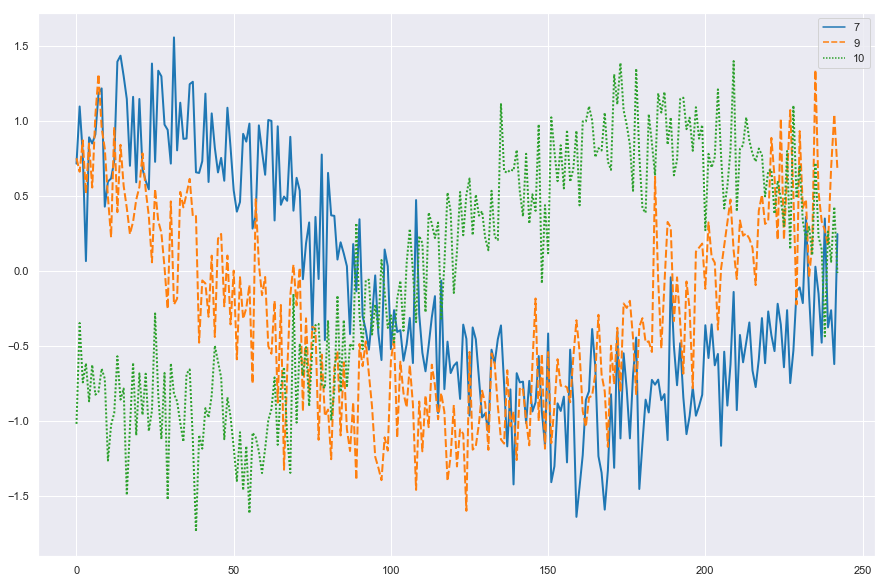

In [9]:
draw_ts(TS=TS_list, ts_anomaly_list=ts_ind, anomaly_list=anomaly_ind, anomaly_ind=4,
        display_ts=3, biased=False, seed=1234, offset=anomaly_len[4], path='data.pdf')

Draw time series with anomalies injected.

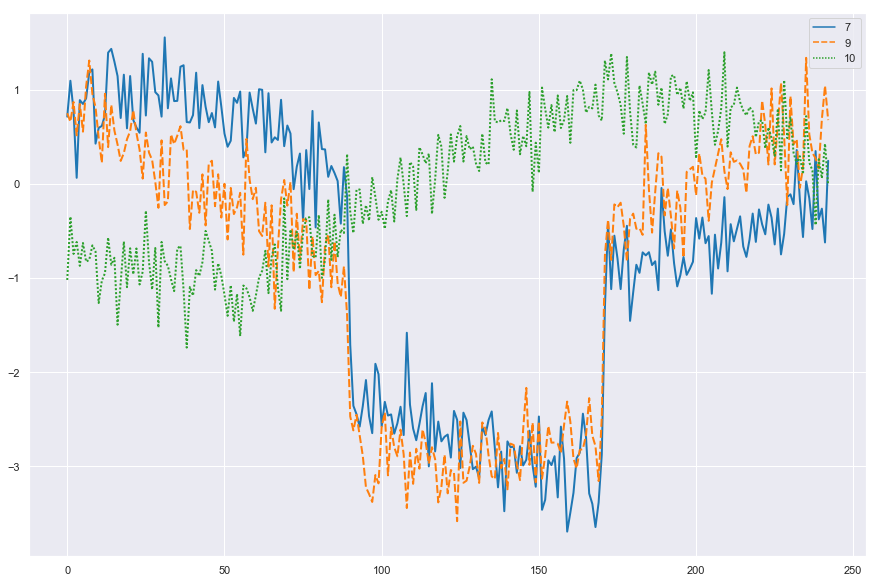

In [10]:
draw_ts(TS=TS_list_anomalies, ts_anomaly_list=ts_ind, anomaly_list=anomaly_ind, anomaly_ind=4,
        display_ts=3, biased=False, seed=1234, offset=anomaly_len[4], path='data_anomalies.pdf')

Compute cross-correlation matrices for the generated time series.

In [11]:
cor_list = get_cross_correlation_list(TS_list, window_size=window_cor_size)
cor_list_anom = get_cross_correlation_list(TS_list_anomalies, window_size=window_cor_size)

Visualize some CCMs.

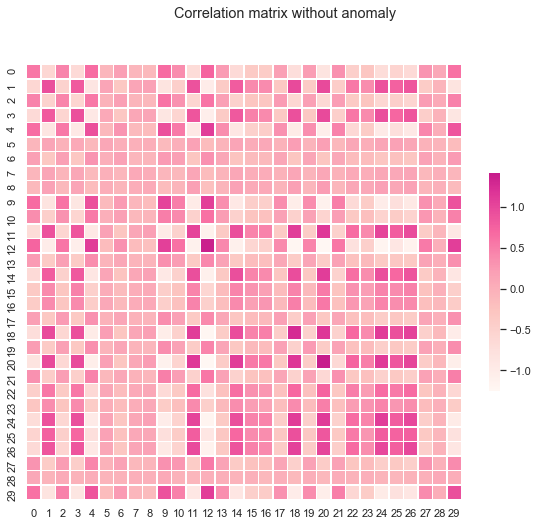

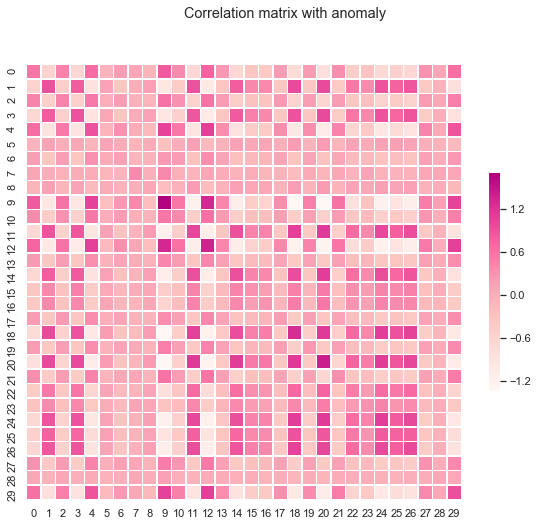

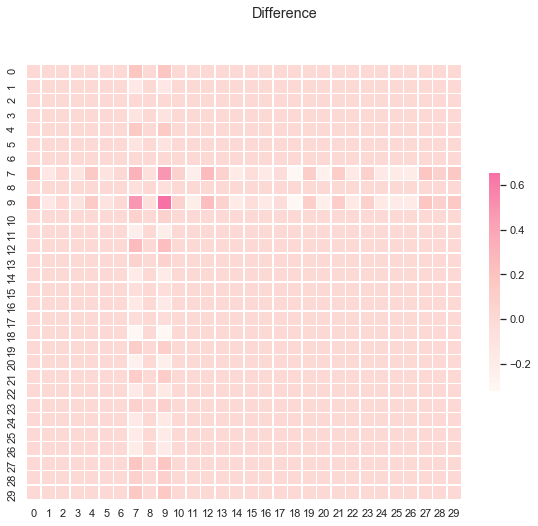

In [12]:
draw_cross_correlation(cor_list[anomaly_ind[4]], title="Correlation matrix without anomaly", path='heatmap.pdf')
draw_cross_correlation(cor_list_anom[anomaly_ind[4]], title="Correlation matrix with anomaly", path='heatmap_anom.pdf')
draw_cross_correlation_difference(cor_list_anom[anomaly_ind[4]], cor_list[anomaly_ind[4]], title="Difference", path='heatmap_dif.pdf')

Split data into __train__, __validation__, __test__ sets. 
We assume that both __train__ and __validation__ datasets do not have any anomalies in them.

__Train__ set is used to train  the model. __Validation__ set is used to estimate the treshold, which is then used to detect anomalies on __test__ set.

In [13]:
train_data = generate_tensor_dataset(cross_cor=cor_list_anom[:train_size], window_size=window_conv_size)
val_data = generate_tensor_dataset(cross_cor=cor_list_anom[train_size:train_size + val_size + window_conv_size], test=True)
test_data = generate_tensor_dataset(cross_cor=cor_list_anom[train_size + val_size + window_conv_size:], test=True)

### Training the model and evaluating results.

Initialize UNET model.

In [14]:
ae_model = UnetAE(in_channels=window_conv_size, num_features=num_ts, BatchNorm=False, Attention=True, multidimensional=False)

Load model from file if needed.

In [15]:
ae_model.load_state_dict(torch.load("models//unet_noBN_ws10_attn_cat.pth"))
ae_model.to(device)
ae_model.eval()

UnetAE(
  (down_path): Sequential(
    (0): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): ConvBlock(


Train the model.

In [69]:
ae_model.to(device)
test_func = lambda model: get_mse_scores(model, val_data, device, reduction='mean')

train_loss, test_loss = train_model(ae_model, train_data, device, batch_size=128, num_epochs=15, test_func=test_func, mu=0.2)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.40it/s]


Save the model.

In [70]:
torch.save(ae_model.state_dict(), "models//unet_noBN_ws10_attn_cat_reg.pth")

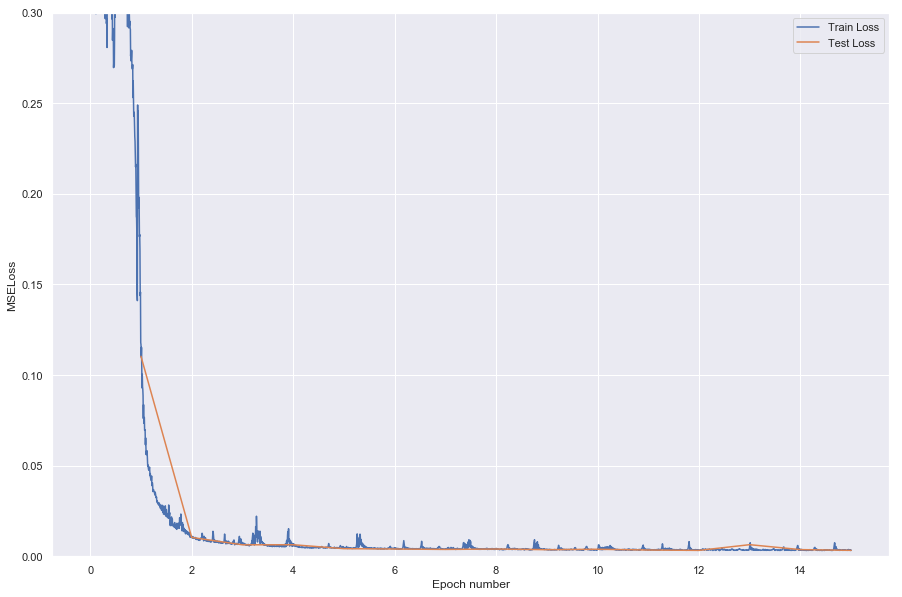

In [72]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(len(train_loss)) / (len(train_loss) - 1) * 15, train_loss, label="Train Loss")
plt.plot(np.arange(len(test_loss)) + 1, test_loss, label='Test Loss')
plt.ylabel('MSELoss')
plt.xlabel('Epoch number')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [73]:
ae_model.eval()

UnetAE(
  (down_path): Sequential(
    (0): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): ConvBlock(
      (layers_list): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): ConvBlock(


Make predictions on validation set to obtain MSE scores.

In [16]:
val_scores = get_mse_scores(ae_model, val_data, device, batch_size=64)
val_scores = val_scores.numpy().ravel()

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 23.15it/s]


Draw MSE score for each timestamp on validation set.

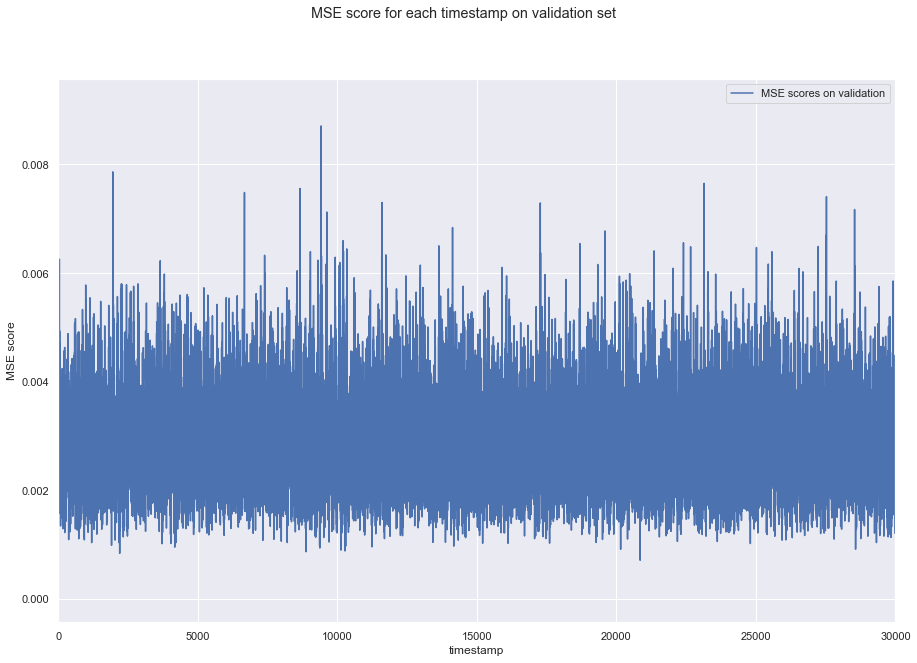

In [18]:
draw_mse_scores(val_scores, label="MSE scores on validation", title="MSE score for each timestamp on validation set", path='mse_on_val.pdf')

Plot MSE score distribution.

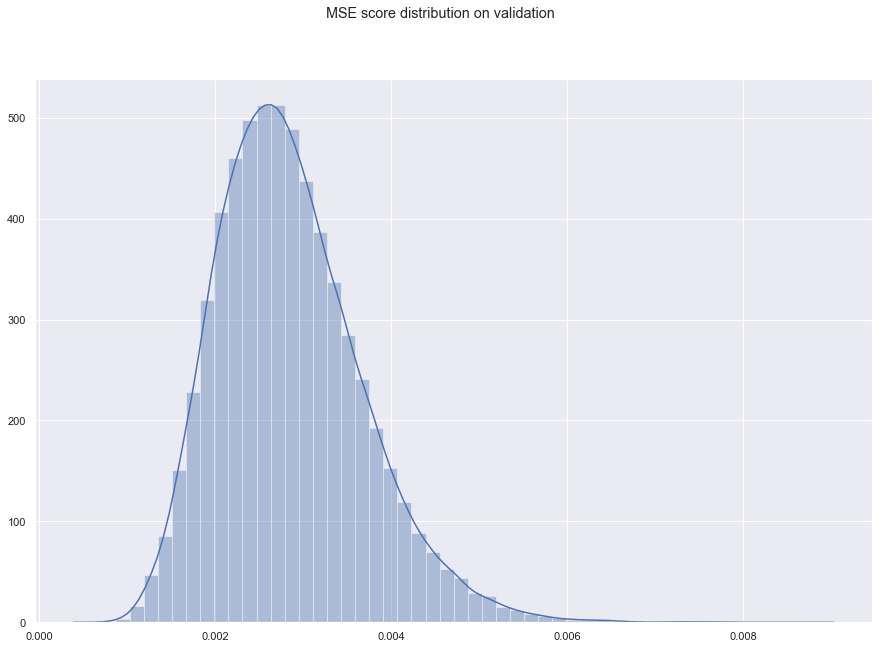

In [21]:
plt.figure(figsize=(15, 10))
plt.suptitle("MSE score distribution on validation")
sns.distplot(val_scores)
plt.show()

In [22]:
gauss_thresh = val_scores.mean() + 3 * val_scores.std()

Get objects for which prediction differs from target the most.

In [25]:
mistakes = np.argsort(val_scores)[-1:]

Timestamp =  9416
Difference =  0.008709603


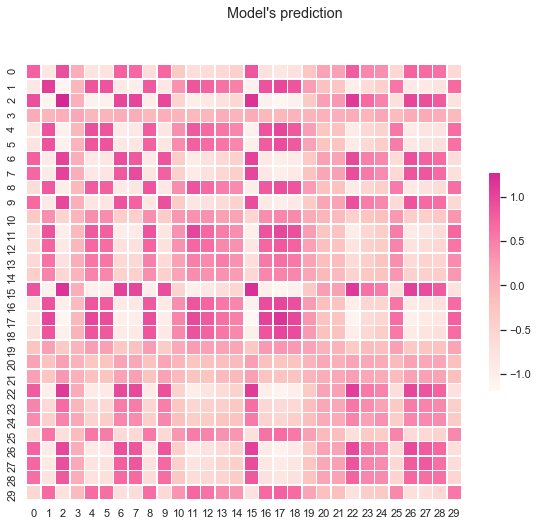

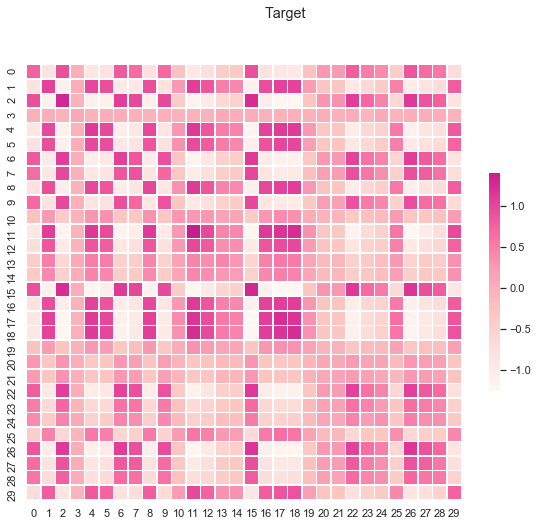

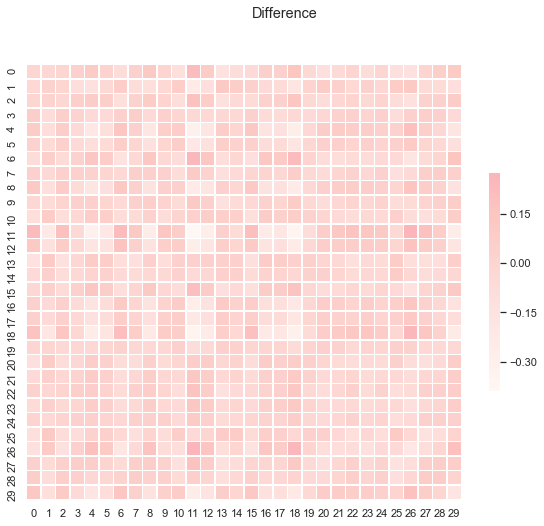

In [27]:
for i in mistakes:
    x, target = val_data[i]
    x, target = x.unsqueeze(0), target.unsqueeze(0)
    print("Timestamp = ", i)
    with torch.no_grad():
        outputs = ae_model(x.to(device)).cpu()
    print('Difference = ', torch.mean((outputs - target) ** 2, (2, 3)).squeeze().numpy())    
    draw_cross_correlation(outputs.squeeze(), "Model's prediction", path='model_pred.pdf')
    draw_cross_correlation(target.squeeze(), "Target", path='true.pdf')
    draw_cross_correlation_difference(outputs.squeeze(), target.squeeze(), "Difference", 'model_pred_dif.pdf')
    

Make predictions on test.

In [28]:
threshold = val_scores.max()

In [29]:
test_scores = get_mse_scores(ae_model, test_data, device)
test_scores = test_scores.numpy().ravel()

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:23<00:00, 22.46it/s]


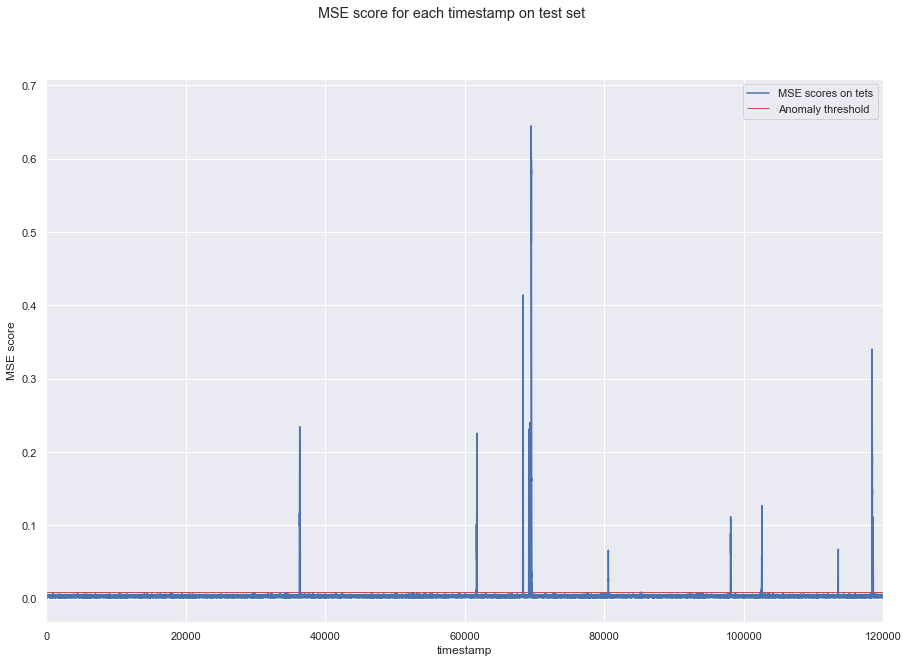

In [30]:
draw_mse_scores(test_scores, label="MSE scores on tets", title="MSE score for each timestamp on test set", threshold=threshold, path='mse_on_test.pdf')

Get indices of anomalies on test set.

In [31]:
anomaly_ind_shifted = sorted(list(zip(anomaly_ind - (train_size + val_size +  2 * window_conv_size),
                                      ts_ind, anomaly_len)), key=lambda x:x[0])
anomaly_ind_shifted

[(36282, array([9]), 151),
 (61669, array([28,  9, 29]), 121),
 (68315, array([7, 9]), 81),
 (69169, array([ 5, 26, 14]), 168),
 (69528, array([ 6, 24, 29]), 157),
 (80583, array([21]), 167),
 (98087, array([19]), 136),
 (102536, array([1]), 87),
 (113487, array([8, 3]), 80),
 (118367, array([14, 17,  6]), 199)]

Make predictions.

In [40]:
detected_anomalies = (test_scores > threshold)

Get true anomalies' indices.

In [41]:
true_anomalies = np.zeros_like(detected_anomalies)
for ai in anomaly_ind_shifted:
    true_anomalies[ai[0]:ai[0] + ai[2]] = 1

[151, 302]


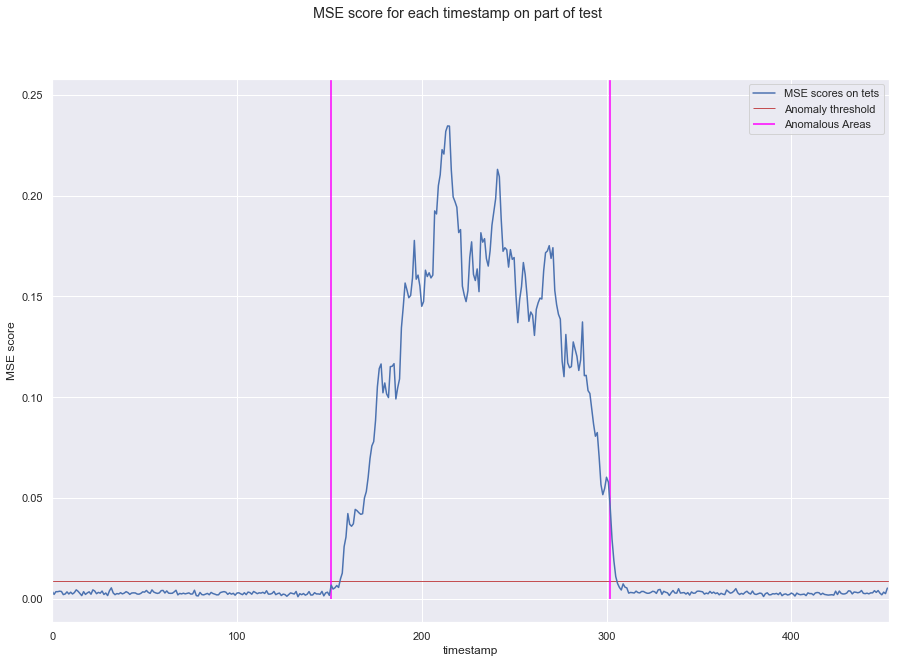

[121, 242]


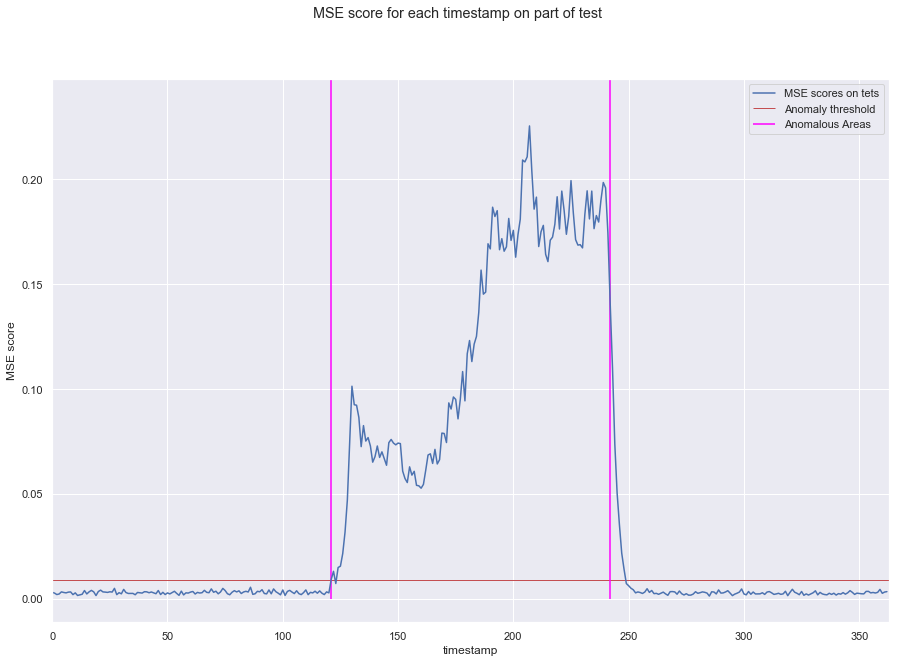

[81, 162]


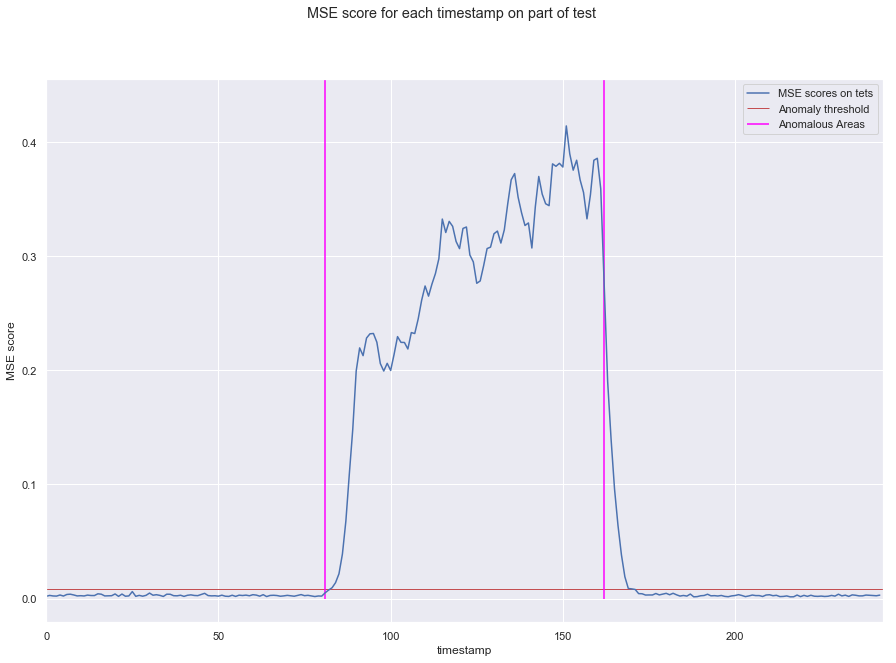

[168, 336]


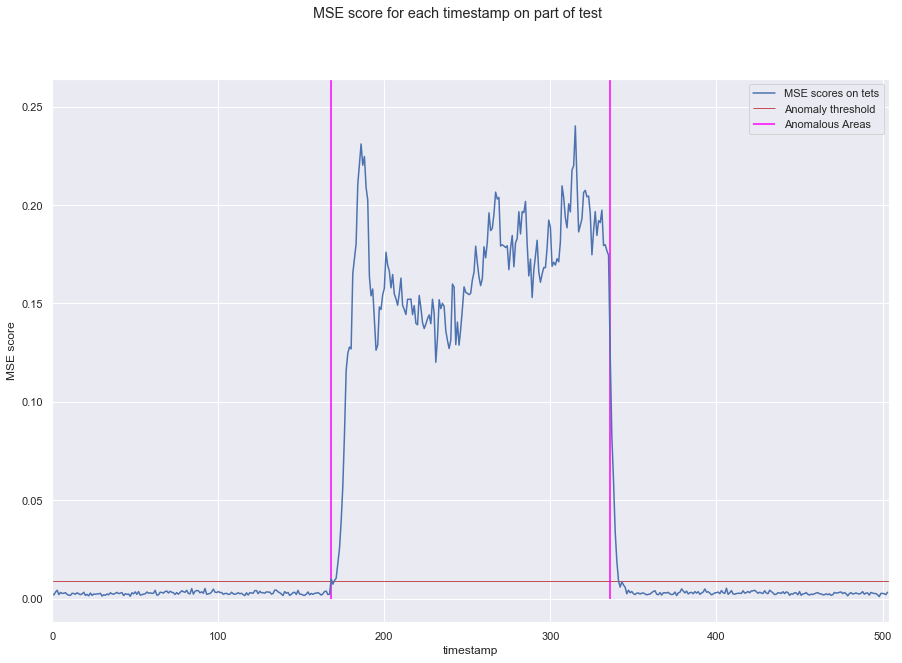

[157, 314]


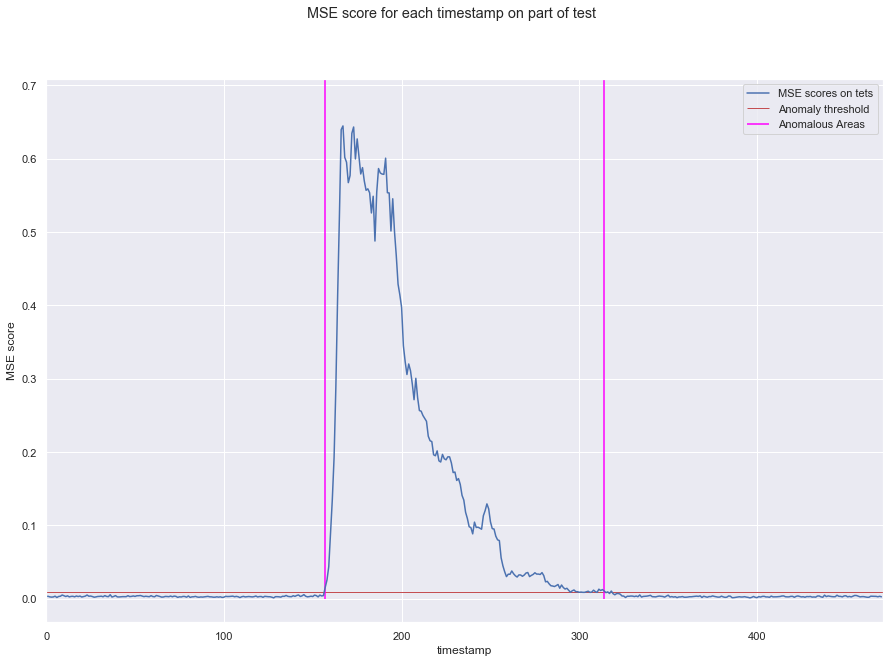

[167, 334]


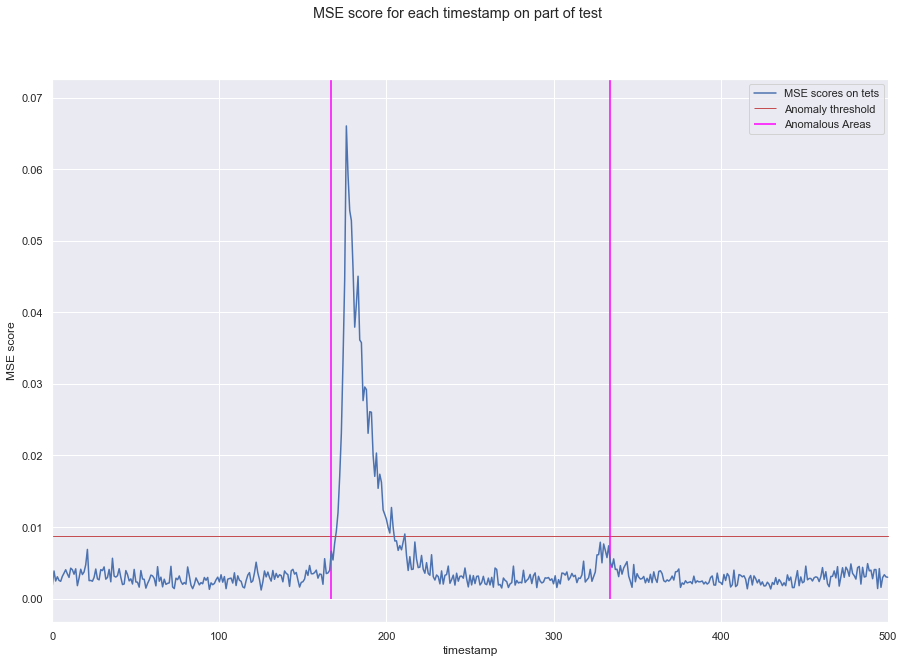

[136, 272]


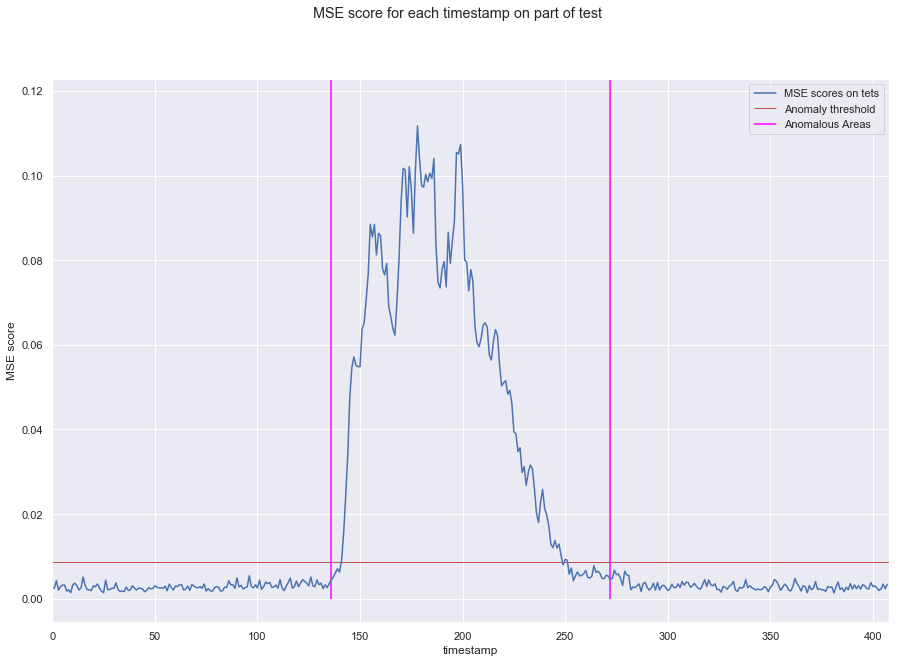

[87, 174]


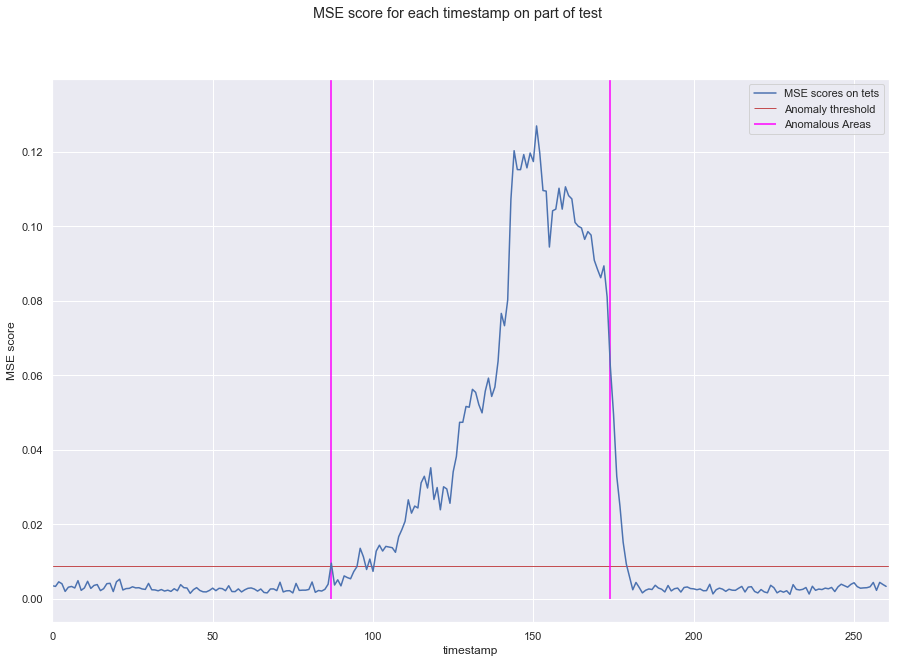

[80, 160]


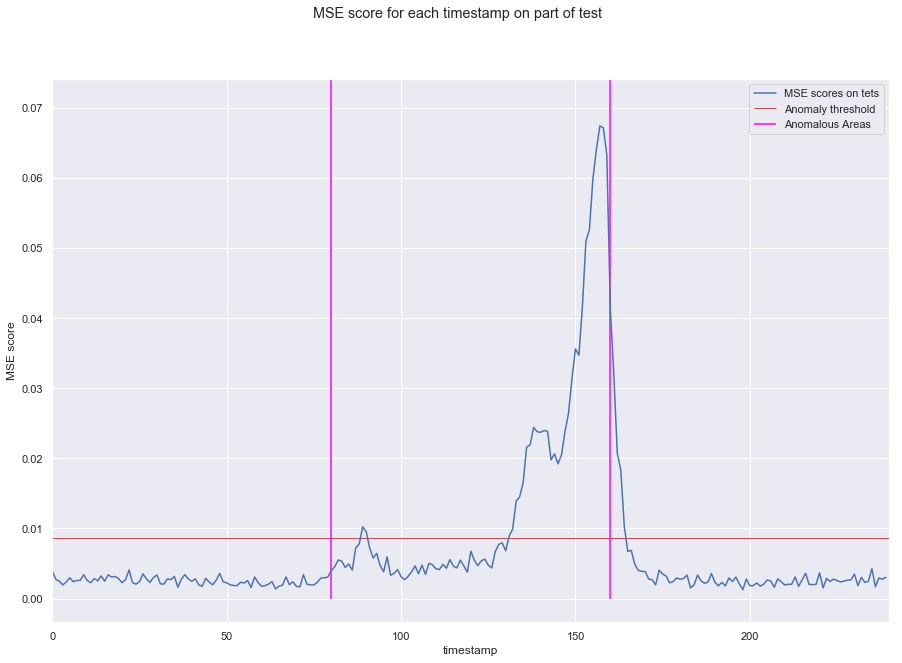

[199, 398]


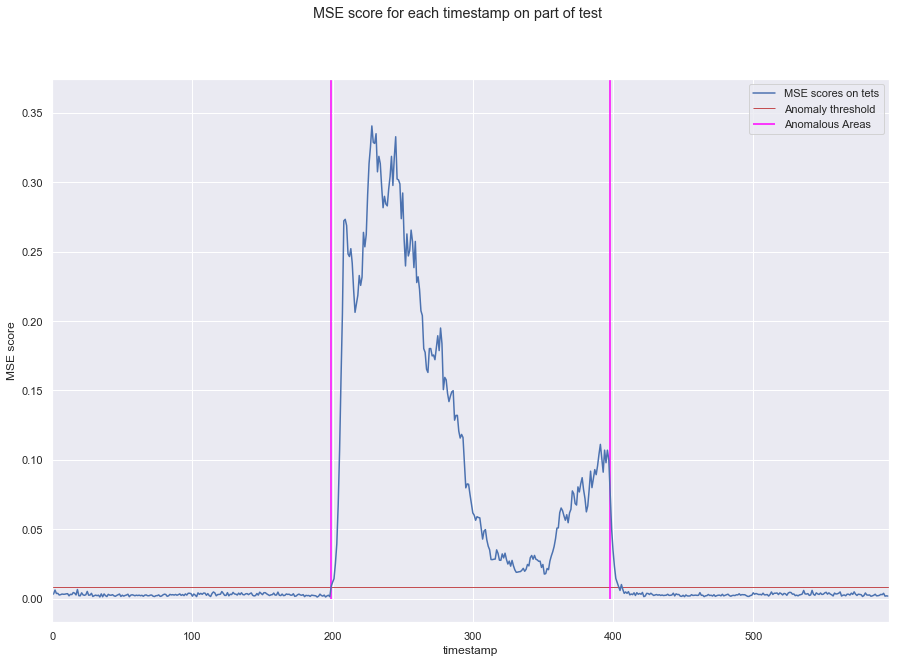

In [42]:
for i in range(len(anomaly_ind_shifted)):
    draw_mse_scores(test_scores[anomaly_ind_shifted[i][0] - anomaly_ind_shifted[i][2]:anomaly_ind_shifted[i][0] + 2 * anomaly_ind_shifted[i][2]],
                    label="MSE scores on tets", title="MSE score for each timestamp on part of test", lims = [anomaly_ind_shifted[i][2], 2 * anomaly_ind_shifted[i][2]],
                    threshold=threshold)

In [43]:
precision, recall, f1 = compute_metrics(true_anomalies, detected_anomalies)

In [44]:
print("F1 score value: {:.4f}. Corresponding precision and recall values {:.4f}, {:.4f}".format(f1, precision, recall))
print("Corresponding_threshold: {:f}".format(threshold))

F1 score value: 0.8892. Corresponding precision and recall values 0.9596, 0.8285
Corresponding_threshold: 0.008710


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.89')

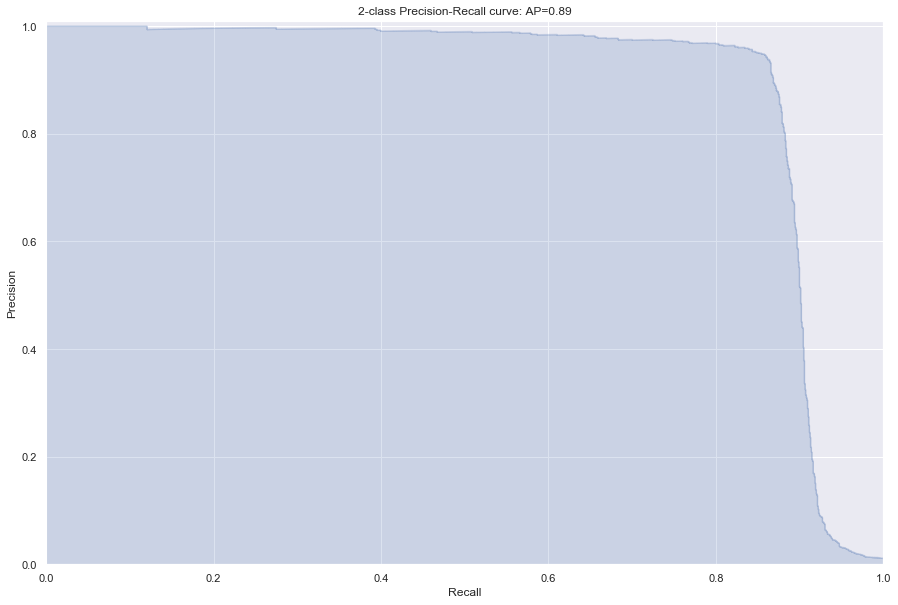

In [108]:
precision, recall, _ = metrics.precision_recall_curve(true_anomalies, test_scores)
average_precision = metrics.average_precision_score(true_anomalies, test_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Root cause identification

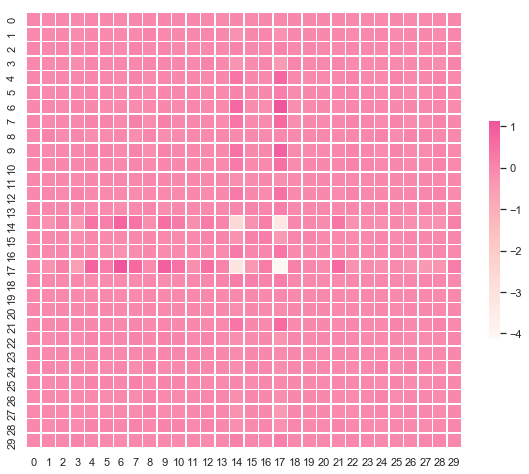

In [45]:
with torch.no_grad():
    x, target = test_data[anomaly_ind_shifted[9][0] + 5]
    out = ae_model(x.unsqueeze(0).to(device)).cpu()
draw_cross_correlation_difference(out.squeeze().numpy(), target.squeeze().numpy(), path='root_cause.pdf')
difference_matr = out.squeeze().numpy() - target.squeeze().numpy()

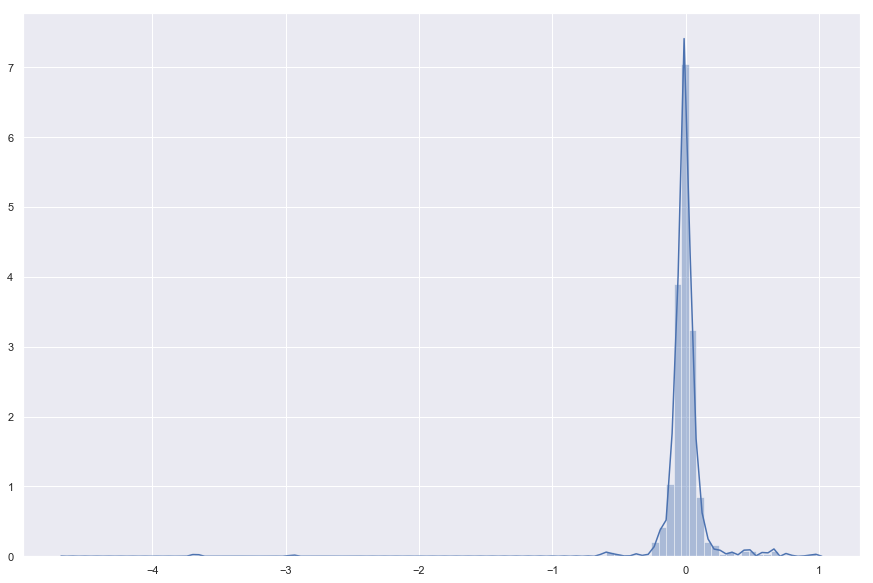

In [91]:
plt.figure(figsize=(15, 10))
sns.distplot(difference_matr.ravel(), bins=100)

In [92]:
std = difference_matr.ravel().std()

In [93]:
difference_matr[np.abs(difference_matr) < std] = 0

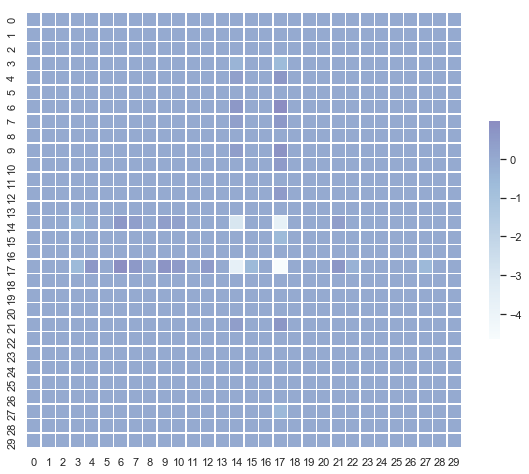

In [94]:
draw_cross_correlation(difference_matr)